[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several fascinating ocean mammals you can explore:\n\n1. **Dolphins:** Highly intelligent and social creatures found in various oceanic environments. There are many species, including the well-known bottlenose dolphin.\n\n2. **Porpoises:** Similar to dolphins but generally smaller and with different facial features. Harbor porpoises are the most widely studied.\n\n3. **Seals:** Found in both polar and temperate waters, seals are known for their streamlined bodies and whiskered faces. Examples include the harbor seal and elephant seal.\n\n4. **Sea Lions:** Also known as eared seals, they are distinguished by their external ear flaps and ability to "walk" on land using their flippers. The California sea lion is a common species.\n\n5. **Walruses:** Large, tusked pinnipeds mainly found in the Arctic. They are well-adapted for life in cold waters and are known for their blubber and whiskers.\n\n6. **Manatees and Dugongs:** Sometimes calle

We can run our chat model in a simple graph with `MessagesState`.

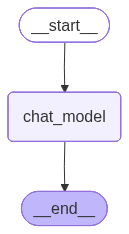

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Aside from whales, there are several intriguing ocean mammals you might find interesting:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are present in oceans worldwide. There are several species, including the bottlenose dolphin and the orca, or killer whale, which is technically a dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller and with different dental anatomy, porpoises are less acrobatic but still fascinating marine mammals.

3. **Seals**: There are many species of seals, which are part of the pinniped family. They are semi-aquatic, spending time both in t

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

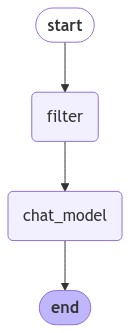

In [7]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are a variety of other fascinating ocean mammals you might be interested in learning about. Here are a few:

1. **Dolphins**: These highly intelligent and social animals are part of the cetacean family, which also includes whales and porpoises. There are many species of dolphins, including the common bottlenose dolphin and the orca, or killer whale, which is actually the largest member of the dolphin family.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures and teeth. The harbor porpoise is one of the more well-known sp

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

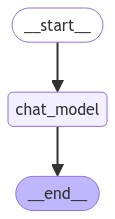

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [13]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

In [14]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

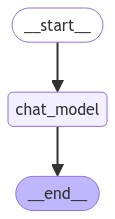

In [15]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [17]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [18]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

In [7]:
# Extension of Messages as a State

In [8]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage("Hey! Are you preparing for the Joint Entrance Exam (JEE)?", name="Bot"),
    HumanMessage("Yes, I just started preparing for it.", name="Devansh"),
    AIMessage("That's great! Which subjects are you focusing on right now?", name="Bot"),
    HumanMessage("Mostly Physics and Maths. Chemistry feels a bit tough for me.", name="Devansh"),
    AIMessage("No worries! With consistent practice, Chemistry will get easier. Do you want some tips for JEE preparation?", name="Bot"),
    HumanMessage("Yes, please! What’s the best way to plan my daily study schedule for JEE?", name="Devansh"),
]

for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Bot

Hey! Are you preparing for the Joint Entrance Exam (JEE)?
================================ Human Message =================================
Name: Devansh

Yes, I just started preparing for it.
================================== Ai Message ==================================
Name: Bot

That's great! Which subjects are you focusing on right now?
================================ Human Message =================================
Name: Devansh

Mostly Physics and Maths. Chemistry feels a bit tough for me.
================================== Ai Message ==================================
Name: Bot

No worries! With consistent practice, Chemistry will get easier. Do you want some tips for JEE preparation?
================================ Human Message =================================
Name: Devansh

Yes, please! What’s the best way to plan my daily study schedule for JEE?


In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content="Creating an effective study schedule for JEE preparation involves balancing time across subjects while considering your personal strengths and areas for improvement. Here are some tips:\n\n1. **Analyze Strengths and Weaknesses**: Spend more time on weaker subjects (like Chemistry for you) but don’t neglect your stronger subjects (like Physics and Maths).\n\n2. **Set Clear Goals**: Divide your plan into daily, weekly, and monthly goals. This helps in tracking progress and staying motivated.\n\n3. **Allocate Time Slots**:\n   - Keep a healthy rotation of subjects to maintain variety and prevent burnout.\n   - Typically, dedicate about 2-3 hours per subject daily, but adjust based on comfort.\n\n4. **Focus on Concepts**: Ensure you spend time understanding concepts before heading into practice problems, especially in Chemistry.\n\n5. **Daily Revision**: Spend at least an hour revisiting what you've learned to reinforce memory.\n\n6. **Regular Practice**:\n   - Solve pre

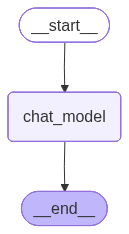

human: Hi, I'm preparing for the Joint Entrance Exam (JEE). Any advice?
ai: Preparing for the Joint Entrance Exam (JEE) requires a strategic approach, as it is one of the most competitive engineering entrance exams in India. Here are some tips that might help you in your preparation:

1. **Understand the Syllabus**: Familiarize yourself with the complete JEE syllabus for both JEE Main and JEE Advanced. Concentrate on the topics that are frequently tested.

2. **Create a Study Plan**: Develop a realistic and structured study schedule. Allocate time daily for each subject (Physics, Chemistry, and Mathematics) and stick to your schedule as closely as possible.

3. **Study Material**: Choose the right books and study material. Some recommended books include:
   - **Physics**: H.C. Verma (Concepts of Physics), Resnick and Halliday, D.C. Pandey (Arihant series).
   - **Chemistry**: O.P. Tandon (Physical, Inorganic, and Organic Chemistry), N.C.E.R.T. textbooks, and Morrison & Boyd (for Organi

In [10]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-4o-mini")

def chat_model_node(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

messages = [
    HumanMessage("Hi, I'm preparing for the Joint Entrance Exam (JEE). Any advice?"),
]

result = graph.invoke({"messages": messages})

for msg in result["messages"]:
    print(f"{msg.name or msg.type}: {msg.content}")

In [11]:
# Reducing Messages

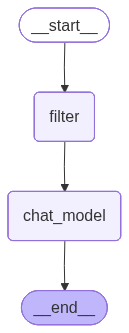

ai: Nice! Which subjects are you focusing on the most right now?
human: Physics and Maths. I find Chemistry a bit hard.
ai: It's great that you're focusing on physics and math! Both subjects can be incredibly rewarding and are often interrelated. If you find chemistry challenging, it might help to approach it slowly and connect it with concepts from physics and math that you're comfortable with. For example, understanding the principles of energy and motion can sometimes clarify certain chemical reactions. If you have specific topics or problems in mind you'd like to discuss or need help with, feel free to ask!


In [12]:
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-4o-mini")

def filter_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

messages = [
    AIMessage("Hey there! Are you preparing for the Joint Entrance Exam (JEE)?"),
    HumanMessage("Yes, I just started my preparation."),
    AIMessage("Nice! Which subjects are you focusing on the most right now?"),
    HumanMessage("Physics and Maths. I find Chemistry a bit hard."),
]

result = graph.invoke({"messages": messages})

for msg in result["messages"]:
    print(f"{msg.type}: {msg.content}")


In [13]:
# Filtering the messages sent to llm while invoking it

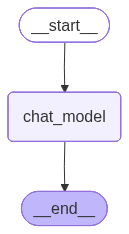

ai: Hey! Are you preparing for the Joint Entrance Exam (JEE)?
human: Yes, I just started preparing for it.
ai: That’s great! Which subjects are you focusing on the most?
human: Mostly Physics and Maths. Chemistry feels a bit hard.
ai: It's common to find chemistry challenging, especially when you're more comfortable with physics and math. Chemistry often requires a good grasp of concepts and the ability to visualize processes at the molecular level. If you have specific topics in chemistry that you're struggling with, feel free to share them! I can help explain those concepts or provide some resources that might make it easier to understand.


In [14]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-4o-mini")

def chat_model_node(state: MessagesState):
    filtered_messages = state["messages"][-2:]
    response = llm.invoke(filtered_messages)
    return {"messages": [response]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

messages = [
    AIMessage("Hey! Are you preparing for the Joint Entrance Exam (JEE)?"),
    HumanMessage("Yes, I just started preparing for it."),
    AIMessage("That’s great! Which subjects are you focusing on the most?"),
    HumanMessage("Mostly Physics and Maths. Chemistry feels a bit hard."),
]

result = graph.invoke({"messages": messages})

for msg in result["messages"]:
    print(f"{msg.type}: {msg.content}")


In [15]:
#Demonstrating Trimming Messages 

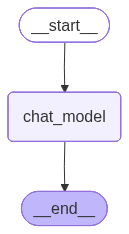

Messages passed to model (6):
  - ai: That’s awesome! How are you planning your daily sc
  - human: I study Physics in the morning and Chemistry in th
  - ai: Good plan! Make sure to keep revising regularly.
  - human: I’m struggling a bit with Organic Chemistry. Any a
  - ai: Focus on mechanisms first — they make memorization
  - human: Got it! Should I solve NCERT first or jump to coac

Model's reply:
ai: Hey! Are you preparing for the Joint Entrance Exam (JEE)?
human: Yes, I just started preparing for it.
ai: That’s awesome! How are you planning your daily schedule?
human: I study Physics in the morning and Chemistry in the evening.
ai: Good plan! Make sure to keep revising regularly.
human: I’m struggling a bit with Organic Chemistry. Any advice?
ai: Focus on mechanisms first — they make memorization easier.
human: Got it! Should I solve NCERT first or jump to coaching materials?
ai: Start with NCERT to build a strong foundation. Once you're comfortable, you can gradually tackle co

In [16]:
from langchain_core.messages import AIMessage, HumanMessage, trim_messages
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-4o-mini")
token_counter = ChatOpenAI(model="gpt-4o")

def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",         
        token_counter=token_counter,
        allow_partial=False,      
    )

    print(f"Messages passed to model ({len(messages)}):")
    for m in messages:
        print(f"  - {m.type}: {m.content[:50]}")

    response = llm.invoke(messages)
    return {"messages": [response]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

messages = [
    AIMessage("Hey! Are you preparing for the Joint Entrance Exam (JEE)?"),
    HumanMessage("Yes, I just started preparing for it."),
    AIMessage("That’s awesome! How are you planning your daily schedule?"),
    HumanMessage("I study Physics in the morning and Chemistry in the evening."),
    AIMessage("Good plan! Make sure to keep revising regularly."),
    HumanMessage("I’m struggling a bit with Organic Chemistry. Any advice?"),
    AIMessage("Focus on mechanisms first — they make memorization easier."),
    HumanMessage("Got it! Should I solve NCERT first or jump to coaching materials?"),
]


result = graph.invoke({"messages": messages})

print("\nModel's reply:")
for msg in result["messages"]:
    print(f"{msg.type}: {msg.content}")
